### Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import seaborn

import os


### Load Dataset :    CIFAR-10

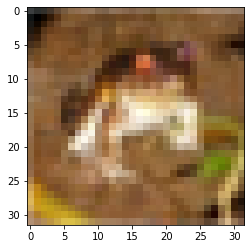

In [3]:
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

x_train, x_test = x_train/255.0, x_test/255.0       # pre-processing: scaling
y_train, y_test = x_train, x_test

plt.imshow(x_train[0])

### Load Noisy image ( targe image )

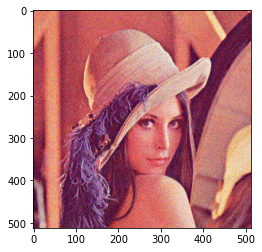

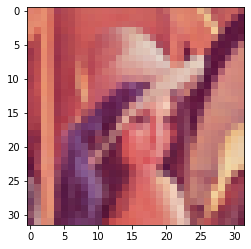

(<matplotlib.image.AxesImage at 0x28a0a9f1e08>, None)

In [4]:
#noisy_image = cv2.imread('../data/noisy.png', cv2.IMREAD_COLOR)
original_image_im = Image.open('../data/noisy.png')
noisy_image_im = original_image_im.resize((32,32))
noisy_image = np.array(noisy_image_im)/255.0

plt.imshow(original_image_im), plt.show()
plt.imshow(noisy_image_im), plt.show()

### Noise NN

In [5]:
noiseNN = tf.keras.models.Sequential([
    tf.keras.layers.GaussianNoise(0.1, input_shape=(32,32,3)),
])

tensor_input = tf.keras.layers.Input((32,32,3, ), name='anchor_input')
noisy_input = noiseNN(tensor_input)

# Train Model

In [6]:
learning_rate = 1e-6

if not os.path.isdir(str(learning_rate)):
       os.makedirs(os.path.join(str(learning_rate)))

### Model #1

In [7]:
model_core = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), input_shape=(32,32,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(3, (3,3), padding='same')
])

restored_output = model_core(noisy_input)
model = tf.keras.models.Model(inputs=tensor_input, outputs=restored_output)

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.Accuracy()]
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
anchor_input (InputLayer)    [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         114307    
Total params: 114,307
Trainable params: 114,307
Non-trainable params: 0
_________________________________________________________________


In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

result = model.fit(
    x_train, y_train, 
    batch_size = 32, 
    epochs = 100,
    shuffle = True,
    verbose = True,
    validation_data = (x_test, y_test),
    callbacks=[callback]
)

model_core.save_weights(str(learning_rate)+'/model1.hdf5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 16s 317us/sample - loss: 0.1374 - accuracy: 1.3021e-08 - val_loss: 0.0325 - val_accuracy: 6.5104e-08
Epoch 2/100
50000/50000 [==============================] - 13s 253us/sample - loss: 0.0279 - accuracy: 1.7578e-07 - val_loss: 0.0227 - val_accuracy: 1.9531e-07
Epoch 3/100
50000/50000 [==============================] - 12s 250us/sample - loss: 0.0183 - accuracy: 1.3672e-07 - val_loss: 0.0123 - val_accuracy: 1.3021e-07
Epoch 4/100
50000/50000 [==============================] - 12s 249us/sample - loss: 0.0097 - accuracy: 1.9531e-07 - val_loss: 0.0060 - val_accuracy: 2.6042e-07
Epoch 5/100
50000/50000 [==============================] - 12s 249us/sample - loss: 0.0056 - accuracy: 2.3437e-07 - val_loss: 0.0035 - val_accuracy: 6.1849e-07
Epoch 6/100
50000/50000 [==============================] - 12s 250us/sample - loss: 0.0041 - accuracy: 2.4740e-07 - val_loss: 0.0025 - val_accuracy: 7

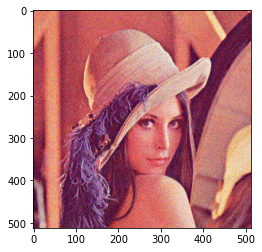

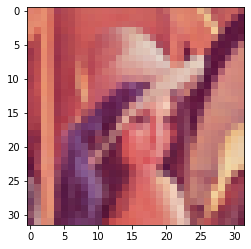

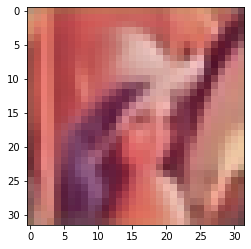

(<matplotlib.image.AxesImage at 0x28ce0f1dcc8>, None)

In [9]:
# predict
restored_images = model_core.predict(np.array([noisy_image]))

# convert to uint8 format
restored_images[0] *= 255.0
restored_image = restored_images[0].astype(np.uint8)

# save it
restored_image_im = Image.fromarray(restored_image)
restored_image_im.save(str(learning_rate)+'/Model1.png')

# show results
plt.imshow(original_image_im), plt.show()
plt.imshow(noisy_image_im), plt.show()
plt.imshow(restored_image_im), plt.show()

### Model #2

In [10]:
model_core = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), input_shape=(32,32,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(3, (3,3), padding='same')
])

restored_output = model_core(noisy_input) + noisy_input
model = tf.keras.models.Model(inputs=tensor_input, outputs=restored_output)

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.Accuracy()]
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32, 32, 3)    0           anchor_input[0][0]               
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 3)    114307      sequential[1][0]                 
__________________________________________________________________________________________________
tf_op_layer_add (TensorFlowOpLa [(None, 32, 32, 3)]  0           sequential_2[1][0]               
                                                                 sequential[1][0]           

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

result = model.fit(
    x_train, y_train, 
    batch_size = 32, 
    epochs = 100,
    shuffle = True,
    verbose = True,
    validation_data = (x_test, y_test),
    callbacks=[callback]
)

model_core.save_weights(str(learning_rate)+'/model2.hdf5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 13s 267us/sample - loss: 0.0101 - accuracy: 1.4323e-07 - val_loss: 1.4939e-04 - val_accuracy: 1.6927e-06
Epoch 2/100
50000/50000 [==============================] - 13s 253us/sample - loss: 0.0086 - accuracy: 1.6276e-07 - val_loss: 3.0306e-04 - val_accuracy: 1.2370e-06
Epoch 3/100
50000/50000 [==============================] - 13s 252us/sample - loss: 0.0065 - accuracy: 2.0833e-07 - val_loss: 5.1182e-04 - val_accuracy: 1.2695e-06
Epoch 4/100
50000/50000 [==============================] - 13s 253us/sample - loss: 0.0047 - accuracy: 2.5391e-07 - val_loss: 6.8949e-04 - val_accuracy: 1.0091e-06
Epoch 5/100
50000/50000 [==============================] - 13s 252us/sample - loss: 0.0036 - accuracy: 2.5391e-07 - val_loss: 7.9000e-04 - val_accuracy: 8.7891e-07
Epoch 6/100
50000/50000 [==============================] - 13s 252us/sample - loss: 0.0030 - accuracy: 2.4089e-07 - val_loss: 8.08

50000/50000 [==============================] - 13s 251us/sample - loss: 0.0019 - accuracy: 4.2318e-07 - val_loss: 8.0920e-04 - val_accuracy: 1.1068e-06
Epoch 51/100
50000/50000 [==============================] - 13s 252us/sample - loss: 0.0019 - accuracy: 3.8411e-07 - val_loss: 8.0773e-04 - val_accuracy: 1.1068e-06
Epoch 52/100
50000/50000 [==============================] - 13s 265us/sample - loss: 0.0019 - accuracy: 3.7109e-07 - val_loss: 8.1368e-04 - val_accuracy: 1.6602e-06
Epoch 53/100
50000/50000 [==============================] - 13s 259us/sample - loss: 0.0019 - accuracy: 2.7995e-07 - val_loss: 8.1412e-04 - val_accuracy: 1.2044e-06
Epoch 54/100
50000/50000 [==============================] - 13s 252us/sample - loss: 0.0019 - accuracy: 4.6224e-07 - val_loss: 8.1141e-04 - val_accuracy: 7.8125e-07
Epoch 55/100
50000/50000 [==============================] - 13s 252us/sample - loss: 0.0019 - accuracy: 4.1667e-07 - val_loss: 8.1719e-04 - val_accuracy: 1.3021e-06
Epoch 56/100
50000/5000

In [ ]:
# predict
restored_images = model_core.predict(np.array([noisy_image]))

# convert to uint8 format
restored_image = (noisy_image + restored_images[0]) * 255.0
restored_image = restored_image.astype(np.uint8)

# save it
restored_image_im = Image.fromarray(restored_image)
restored_image_im.save(str(learning_rate)+'/Model2.png')

# show results
plt.imshow(original_image_im), plt.show()
plt.imshow(noisy_image_im), plt.show()
plt.imshow(restored_image_im), plt.show()

### Model #3

In [ ]:
model_core = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), input_shape=(32,32,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),    
    tf.keras.layers.Conv2D(3, (3,3), padding='same')
])

restored_output = model_core(noisy_input) + noisy_input
model = tf.keras.models.Model(inputs=tensor_input, outputs=restored_output)

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.Accuracy()]
)

model.summary()

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

result = model.fit(
    x_train, y_train, 
    batch_size = 32, 
    epochs = 100,
    shuffle = True,
    verbose = True,
    validation_data = (x_test, y_test),
    callbacks=[callback]
)

model_core.save_weights(str(learning_rate)+'/model3.hdf5')

In [ ]:
# predict
restored_images = model_core.predict(np.array([noisy_image]))

# convert to uint8 format
restored_image = (noisy_image + restored_images[0]) * 255.0
restored_image = restored_image.astype(np.uint8)

# save it
restored_image_im = Image.fromarray(restored_image)
restored_image_im.save(str(learning_rate)+'/Model3.png')

# show results
plt.imshow(original_image_im), plt.show()
plt.imshow(noisy_image_im), plt.show()
plt.imshow(restored_image_im), plt.show()